## Unsupervised Machine Learning - Notes from mysefl to future myself 

### 1. Motivation
In this example i chosed my smallest work, which has initial resolution of 6454 x 13484. I'm working on my own startup relate to damage calculation using photogrammety images captured by drone. If i manage to detect corn or other crops i can move to calculate damage on selected chunks to automate process of identifying damage, marking it and finally calculate totad damage on selected area

### 2. Image
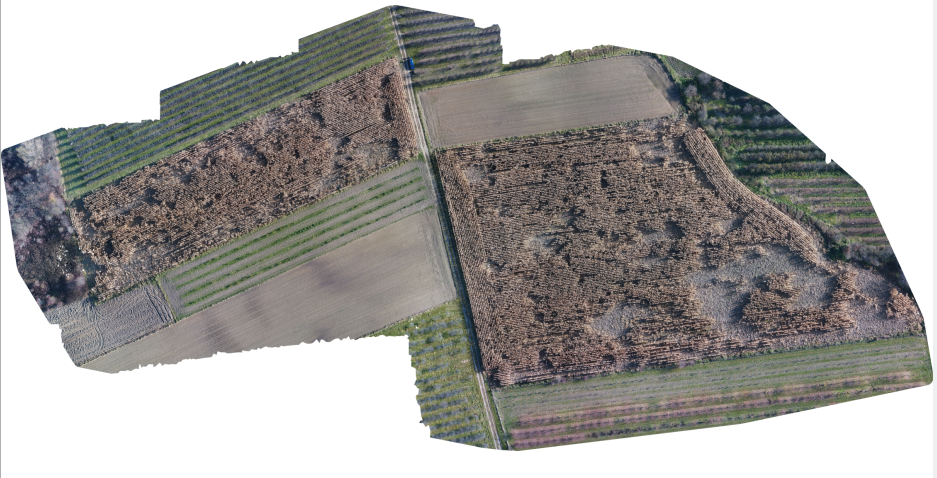
### 3. Source
To implement this soultion ill be deriving from this [python notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb), grabbed from this [stacoverflow question](https://stackoverflow.com/questions/55681649/how-to-build-an-unsupervised-cnn-model-with-keras-tensorflow) 
*note*
This answer is provided by TensorFlow Support which i find quite funny

### 4. Parsing images
It turns out that `.tiff` file extension is not parsable by `tf.keras.preprocessing.image.ImageDataGenerator` method, therefore you need to do it by hand with `tfio.experimental.image.decode_tiff`.

### 5. Setup:

In [1]:
# some preparation to make it:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from PIL import Image

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2023-05-10 17:02:06.716757: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 17:02:06.756508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 17:02:06.757068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 17:02:07.356422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
TRAIN = "./splited/train/tiles_test/"
VALID = "./classes/"

In [3]:
def parse_tiff(pic: str):
    im = Image.open(str(pic))
    im = np.array(im)
    if (im.shape[0] == 100) and (im.shape[1] == 100):
        r = im[:, :, 0]
        g = im[:, :, 1]
        b = im[:, :, 2]
        return [r, g, b]

In [4]:
# train dataset
import glob
train_dataset = []

for pic in glob.glob(f"{TRAIN}*.tif"):
    im = Image.open(pic)
    im = np.array(im)
    if (im.shape[0] == 100) and (im.shape[1] == 100):
        r = im[:, :, 0]
        g = im[:, :, 1]
        b = im[:, :, 2]
        train_dataset.append([r, g, b])

train_dataset = np.array(train_dataset).transpose(0, 2, 3, 1)
train_dataset.shape

(4225, 100, 100, 3)

In [5]:
#val dataset
x_test = []
y_test = []

label = 0
for x in ["corn", "damaged", "no_corn"]:
    cnt = 0
    for pic in glob.glob(f"./classes/{x}/*.tif"):
        im = Image.open(pic)
        im = np.array(im)
        if (im.shape[0] == 100) and (im.shape[1] == 100):
            r = im[:, :, 0]
            g = im[:, :, 1]
            b = im[:, :, 2]
            x_test.append([r, g, b])
            y_test.append(label)
    label += 1

x_test = np.array(x_test).transpose(0, 2, 3, 1)
#y_test = np.array(y_test)
x_test.shape
print(y_test[-1])

2


In [6]:
import random
train_dataset = train_dataset.astype('float32')
x_test = x_test.astype('float32')
train_dataset /= 255
x_test /= 255
print(x_test.shape)

zipped = list(zip(x_test, y_test))
random.shuffle(zipped)
x_test, y_test = zip(*zipped)
x_test = np.array(x_test)
print(type(x_test))

x_test, x_val = x_test[:241, :], x_test[242:, :]
y_test, y_val = y_test[:241], y_test[242:]

(483, 100, 100, 3)
<class 'numpy.ndarray'>


In [7]:
print(len(y_test))
print(len(y_val))

241
241


In [8]:
print(y_test)

(2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 2, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0)


### Stacked Autoencoders


In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    #keras.layers.Conv2D(50, kernel_size=(3, 3), activation='relu', input_shape=[100, 100, 3]),
    keras.layers.Flatten(input_shape=[100,100,3]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(50, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[50]),
    keras.layers.Dense(100 * 100 * 3, activation="softmax"),
    keras.layers.Reshape([100, 100, 3])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(train_dataset, train_dataset, epochs=20,
                         validation_data=(x_test, x_test))

2023-05-10 17:02:54.671840: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 507000000 exceeds 10% of free system memory.


Epoch 1/20


2023-05-10 17:02:55.155461: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 507000000 exceeds 10% of free system memory.


133/133 [==============================] - 5s 33ms/step - loss: 4.2741 - rounded_accuracy: 0.6302 - val_loss: 4.5075 - val_rounded_accuracy: 0.5806
Epoch 2/20
133/133 [==============================] - 4s 31ms/step - loss: 4.2740 - rounded_accuracy: 0.6302 - val_loss: 4.5074 - val_rounded_accuracy: 0.5806
Epoch 3/20
133/133 [==============================] - 4s 31ms/step - loss: 4.2739 - rounded_accuracy: 0.6302 - val_loss: 4.5072 - val_rounded_accuracy: 0.5806
Epoch 4/20
133/133 [==============================] - 4s 31ms/step - loss: 4.2738 - rounded_accuracy: 0.6302 - val_loss: 4.5073 - val_rounded_accuracy: 0.5806
Epoch 5/20
133/133 [==============================] - 4s 31ms/step - loss: 4.2737 - rounded_accuracy: 0.6302 - val_loss: 4.5073 - val_rounded_accuracy: 0.5806
Epoch 6/20
133/133 [==============================] - 4s 31ms/step - loss: 4.2736 - rounded_accuracy: 0.6302 - val_loss: 4.5071 - val_rounded_accuracy: 0.5806
Epoch 7/20
133/133 [==============================] - 4s 

In [12]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(x_val)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())


8/8 [==============================] - 0s 4ms/step


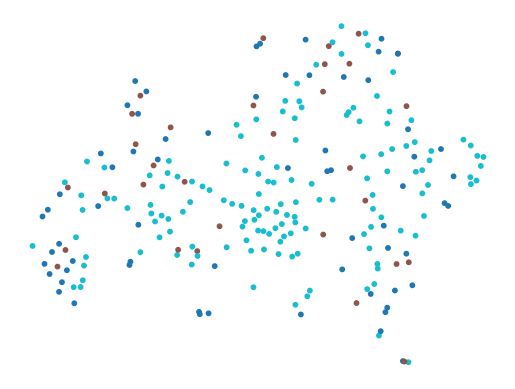

In [13]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_val, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


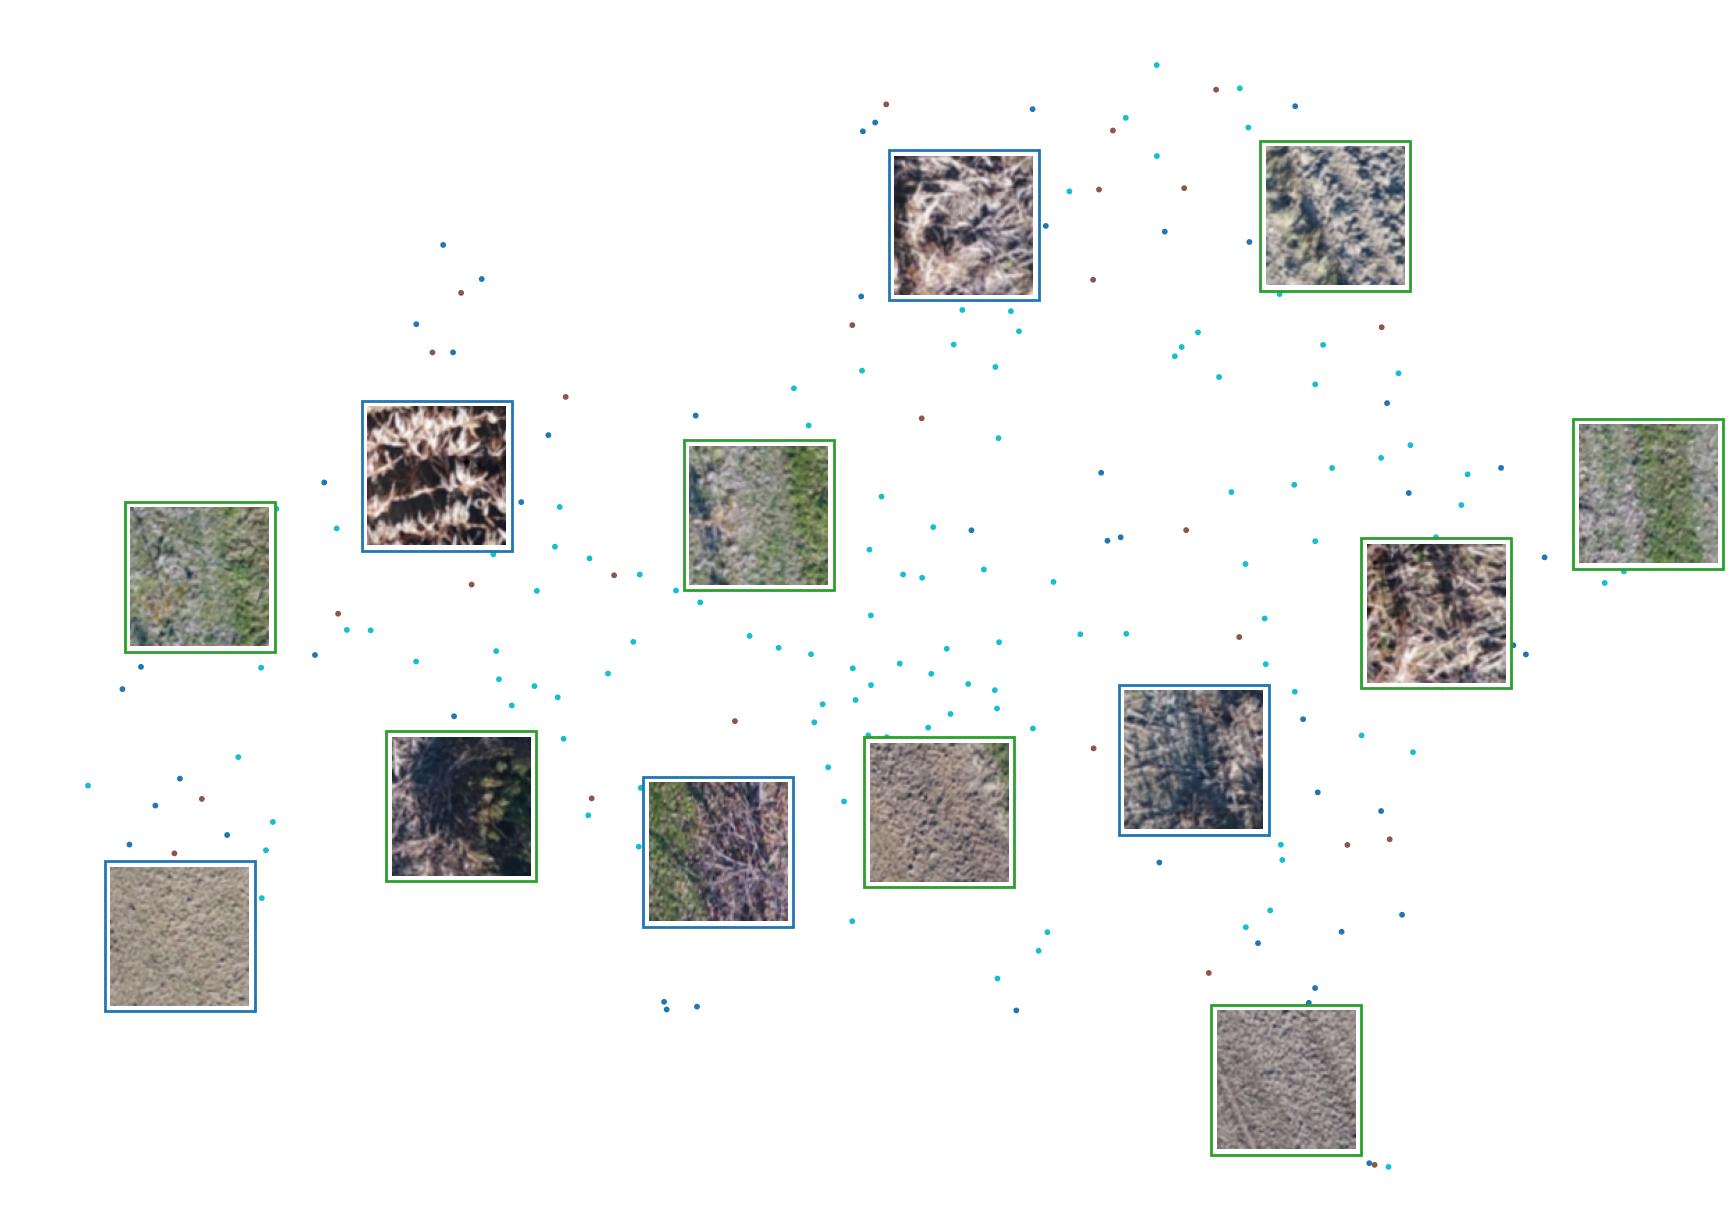

In [14]:

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(20, 14))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_val, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_val[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

In [15]:
print(len(x_test))

241


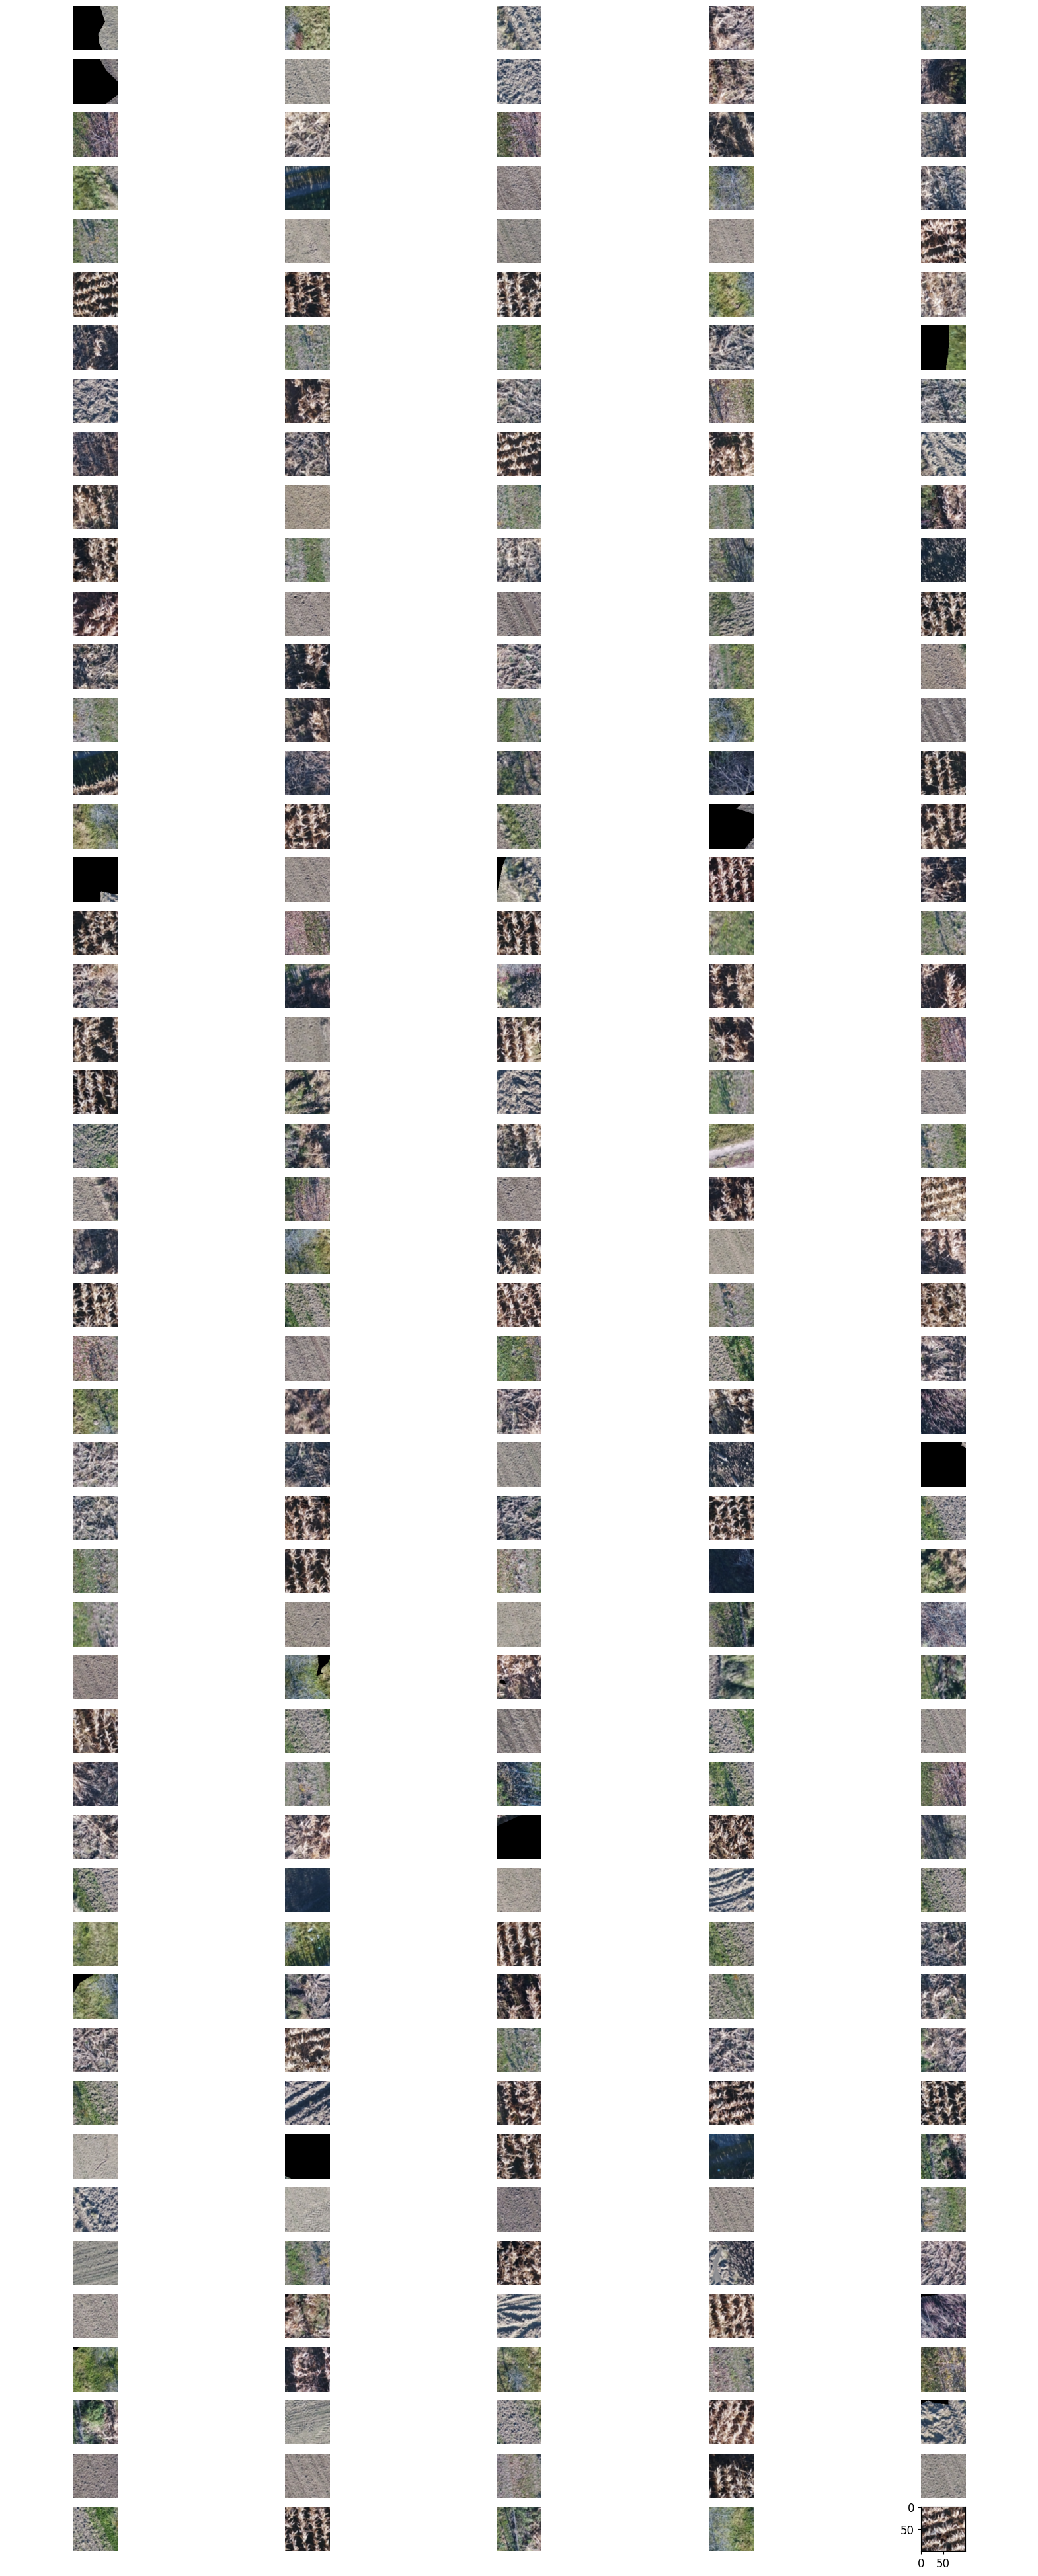

In [16]:
cols = 5
rows = 48
fig = plt.figure(figsize=(20, 50))
idx = 0
for i in range(1, cols*rows +1):
    plt.axis("off")
    fig.add_subplot(rows, cols, i)
    plt.imshow(x_test[i], cmap='gray')
plt.show()

In [ ]:
# classes 

for x in range(3):
    for y in 